# Clean Metadata
This notebook processes raw metadata provided by GISAID into the format required by Augur. Furthermore, it extracts additional information into unique variables.

## Setup

### Imports

In [1]:
import glob
import numpy as np
import pandas as pd
import plotnine as p9
import re

# Custom cleaning functions
from data.prep_data.clean_seqs import clean_strain_names
from data.prep_data.clean_seqs import deduplicate

### Files

#### Inputs

In [2]:
region = "europe"

In [3]:
input_gisaid_files = glob.glob(f'h3n2/data/raw/*{region}*.xls')

#### Outputs



In [4]:
export_augur = f'h3n2/data/clean/{region}_clean.tsv'

### Parameters

## Load raw data from GISAID

In [5]:
# Read each file into a dataframe
dfs = [pd.read_excel(file) for file in input_gisaid_files]

# Join all dataframes into one
meta_raw = pd.concat(dfs, ignore_index=True)
meta_raw.head()

,Isolate_Id,PB2 Segment_Id,PB1 Segment_Id,PA Segment_Id,HA Segment_Id,NP Segment_Id,NA Segment_Id,MP Segment_Id,NS Segment_Id,HE Segment_Id,...,PB2 INSDC_Upload,PB1 INSDC_Upload,PA INSDC_Upload,HA INSDC_Upload,NP INSDC_Upload,NA INSDC_Upload,MP INSDC_Upload,NS INSDC_Upload,HE INSDC_Upload,P3 INSDC_Upload
0,EPI_ISL_11985635,NaN,NaN,EPI2017364|A/Netherlands/00525/2022_22000533I_...,EPI2017366|A/Netherlands/00525/2022_22000533I_...,NaN,EPI2017365|A/Netherlands/00525/2022_22000533I_...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPI_ISL_11985644,NaN,NaN,EPI2017367|A/Netherlands/00526/2022_22000534I_...,EPI2017369|A/Netherlands/00526/2022_22000534I_...,NaN,EPI2017368|A/Netherlands/00526/2022_22000534I_...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPI_ISL_11985655,NaN,NaN,NaN,EPI2017385|A/Netherlands/00553/2022_22000561I_...,NaN,EPI2017384|A/Netherlands/00553/2022_22000561I_...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPI_ISL_11985665,NaN,NaN,EPI2017412|A/Netherlands/00541/2022_22000549I_...,EPI2017414|A/Netherlands/00541/2022_22000549I_...,NaN,EPI2017413|A/Netherlands/00541/2022_22000549I_...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EPI_ISL_12124635,NaN,NaN,NaN,EPI2020872|A/Netherlands/00574/2022_22000582I_...,NaN,EPI2020871|A/Netherlands/00574/2022_22000582I_...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Keep only the columns we are interested in.

In [6]:
retained_cols = [
    'Isolate_Name',
    'Collection_Date',
    'Isolate_Id',
    'Location',
    'Host',
    'Submitting_Lab',
    'Originating_Lab']

meta_working = meta_raw[retained_cols]

Standardize column name formatting:
- all lowercase
- underscore for word separation (already true)

In [7]:
meta_working.columns = [c.lower() for c in meta_working.columns]

Provide [required columns](https://docs.nextstrain.org/projects/ncov/en/wdl-optionals/analysis/data-prep.html#required-metadata) for Nextstrain.

In [8]:
meta_working = meta_working.rename(
    columns = {
        'isolate_name': 'strain',
        'collection_date': 'date'
    }
)
meta_working['virus'] = 'h3n2_flu'

In [9]:
meta_working.head(n=20)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus
0,A/Netherlands/00525/2022,2022-04-01,EPI_ISL_11985635,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu
1,A/Netherlands/00526/2022,2022-04-01,EPI_ISL_11985644,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu
2,A/Netherlands/00553/2022,2022-04-02,EPI_ISL_11985655,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu
3,A/Netherlands/00541/2022,2022-04-02,EPI_ISL_11985665,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu
4,A/Netherlands/00574/2022,2022-04-01,EPI_ISL_12124635,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu
5,A/Netherlands/00579/2022,2022-04-03,EPI_ISL_12124649,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu
6,A/Netherlands/00583/2022,2022-04-03,EPI_ISL_12124669,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu
7,A/Netherlands/00586/2022,2022-04-05,EPI_ISL_12124683,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu
8,A/Netherlands/00601/2022,2022-04-01,EPI_ISL_12124697,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu
9,A/Netherlands/00605/2022,2022-04-01,EPI_ISL_12124708,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu


## Parse metadata

### Parse country

In [10]:
split_columns = meta_working['location'].str.split(' / ', expand=True)
meta_working['region'] = split_columns[0]
meta_working['country'] = split_columns[1]

In [11]:
meta_working.head(n=10)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus,region,country
0,A/Netherlands/00525/2022,2022-04-01,EPI_ISL_11985635,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu,Europe,Netherlands
1,A/Netherlands/00526/2022,2022-04-01,EPI_ISL_11985644,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu,Europe,Netherlands
2,A/Netherlands/00553/2022,2022-04-02,EPI_ISL_11985655,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu,Europe,Netherlands
3,A/Netherlands/00541/2022,2022-04-02,EPI_ISL_11985665,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu,Europe,Netherlands
4,A/Netherlands/00574/2022,2022-04-01,EPI_ISL_12124635,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu,Europe,Netherlands
5,A/Netherlands/00579/2022,2022-04-03,EPI_ISL_12124649,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu,Europe,Netherlands
6,A/Netherlands/00583/2022,2022-04-03,EPI_ISL_12124669,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu,Europe,Netherlands
7,A/Netherlands/00586/2022,2022-04-05,EPI_ISL_12124683,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu,Europe,Netherlands
8,A/Netherlands/00601/2022,2022-04-01,EPI_ISL_12124697,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu,Europe,Netherlands
9,A/Netherlands/00605/2022,2022-04-01,EPI_ISL_12124708,Europe / Netherlands,Human,Erasmus Medical Center,Erasmus Medical Center,h3n2_flu,Europe,Netherlands


## Clean dataframe
Clean up values.

Clean strain names
* strip leading and trailing whitespace
* replace spaces with underscores
* replace apostrophes with dashes

In [12]:
meta_working['strain'] = (
    meta_working['strain']
    .apply(lambda x: clean_strain_names(x))
)

In [13]:
meta_working.head(n=10)['strain']

0    A/Netherlands/00525/2022
1    A/Netherlands/00526/2022
2    A/Netherlands/00553/2022
3    A/Netherlands/00541/2022
4    A/Netherlands/00574/2022
5    A/Netherlands/00579/2022
6    A/Netherlands/00583/2022
7    A/Netherlands/00586/2022
8    A/Netherlands/00601/2022
9    A/Netherlands/00605/2022
Name: strain, dtype: object

### Deduplicate strains

In [14]:
meta_working = deduplicate(meta_working, 'strain')

Originally, there were 32331 records.
	There were 29764 unique records.
	After cleaning, there were 29764 records remaining.


### Clean up countries

In [15]:
meta_working['country'].value_counts(dropna=False)

country
United Kingdom                                5268
Spain                                         4299
Russian Federation                            3180
Netherlands                                   2764
France                                        2387
Germany                                       2183
Denmark                                       1325
Norway                                        1189
Italy                                          966
Portugal                                       824
Austria                                        687
Romania                                        566
Sweden                                         526
Belgium                                        405
Luxembourg                                     380
Switzerland                                    300
Finland                                        224
Slovenia                                       214
Ukraine                                        205
Croatia                

In [16]:
meta_working['country'] = (
    meta_working['country']
    .replace(
        {"Macedonia, the former Yogoslav Republic of": 'Macedonia',
         'Moldova, Republic of  ': 'Moldova',}
    ))

In [17]:
meta_working['country'].value_counts(dropna=False)

country
United Kingdom            5268
Spain                     4299
Russian Federation        3180
Netherlands               2764
France                    2387
Germany                   2183
Denmark                   1325
Norway                    1189
Italy                      966
Portugal                   824
Austria                    687
Romania                    566
Sweden                     526
Belgium                    405
Luxembourg                 380
Switzerland                300
Finland                    224
Slovenia                   214
Ukraine                    205
Croatia                    185
Slovakia                   164
Estonia                    146
Ireland                    130
Poland                     129
Iceland                    125
Serbia                     124
Czech Republic             122
Bulgaria                   117
Greece                     104
Albania                     81
Macedonia                   73
Hungary                     63


## Export for Augur
Export tab-delimited file (TSV) for input into Augur.

- Replace `NaN` values with a question mark character (`?`), as preferred by Augur.
- Drop raw columns that have been parsed to new, expanded columns.
- Put columns in preferred order. This is not necessary for Augur, but provides a standard order for my own human reading.
- **Drop duplicate strains.**

In [18]:
col_order = [
    'strain',
    'date',
    'virus',
    'region', 
    'country',
    'host', 
    'isolate_id',
    'submitting_lab',
    'originating_lab']

meta_working = meta_working[col_order]

meta_clean = meta_working.fillna('?')

meta_clean.to_csv(export_augur, sep='\t', index=False, header=False)

## Plot and list all strains by country

### Plot strain counts by country

In [19]:
meta_clean['strain'].count()

29764

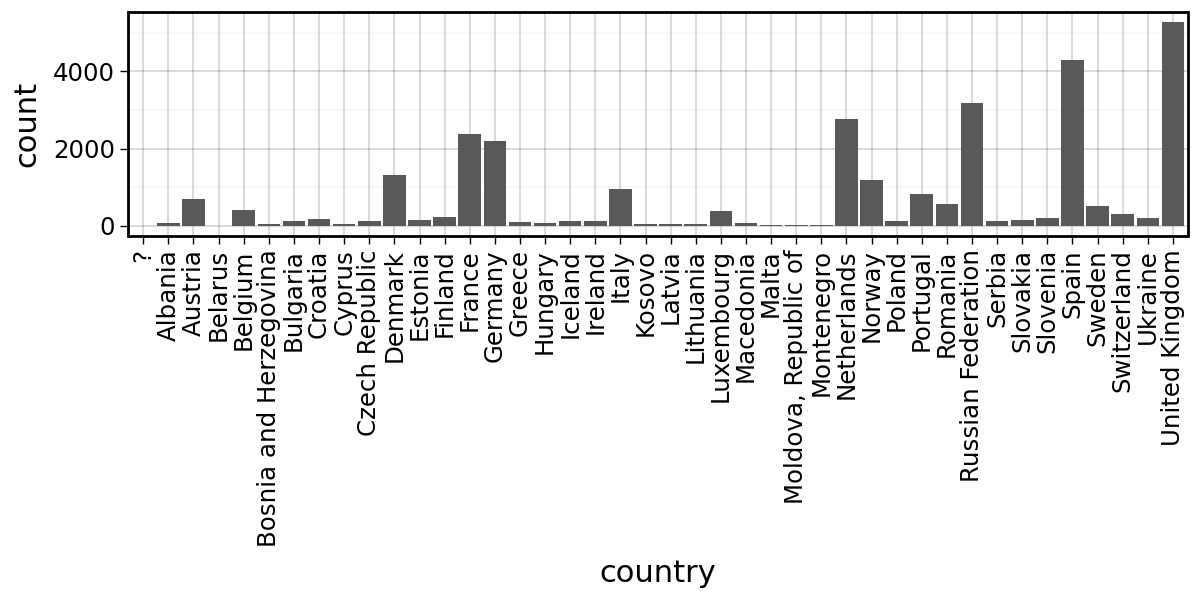

In [20]:
seqs_by_country = (
    p9.ggplot(meta_clean, p9.aes(x='country'))
    + p9.geom_bar()
    + p9.theme_linedraw()
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5))  # Adjust hjust value here
    + p9.theme(figure_size=(6, 3))
)

seqs_by_country


### List strains by country

In [21]:
by_country = meta_working.groupby('country')['strain'].unique()
for key, value in by_country.items():
    print(f"{key} (n={len(value)})")
    for v in value:
        print(v)

Albania (n=81)
A/Albania/289788/2022
A/Albania/289678/2022
A/Albania/289680/2022
A/Albania/9669/2019
A/Albania/9918/2019
A/Albania/0080/2019
A/Albania/9933/2019
A/Albania/0103/2019
A/Albania/9142/2019
A/Albania/9076/2019
A/Albania/974/2021
A/Albania/935/2021
A/Albania/890/2021
A/Albania/863/2021
A/Albania/862/2021
A/Albania/847/2021
A/Albania/840/2021
A/Albania/831/2021
A/Albania/622/2021
A/Albania/616/2021
A/Albania/78/2021
A/Albania/31/2021
A/Albania/9987/2021
A/Albania/9985/2021
A/Albania/9984/2021
A/Albania/9980/2021
A/Albania/9977/2021
A/Albania/9876/2021
A/Albania/9873/2021
A/Albania/9833/2021
A/Albania/9740/2021
A/Albania/9725/2021
A/Albania/9695/2021
A/Albania/9434/2021
A/Albania/9153/2021
A/Albania/8975/2021
A/Albania/8679/2021
A/Albania/8614/2021
A/Albania/8520/2021
A/Albania/8441/2021
A/Albania/323/2021
A/Albania/293/2021
A/Albania/8383/2021
A/Albania/8322/2021
A/Albania/8083/2021
A/Albania/290567/2023
A/Albania/290569/2023
A/Albania/290580/2023
A/Albania/290586/2023
A/Alban